In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [29]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from PIL import Image
import os 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import Model
from keras.layers import Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [34]:
data = []
labels = []
classes = 9

In [31]:
root_dir="/content/drive/MyDrive/KeyFrames-UCF101"

In [32]:
l=os.listdir(root_dir)

In [33]:
print(l)

['Archery', 'Basketball', 'Bowling', 'HorseRace', 'PlayingPiano', 'RopeClimbing', 'SkyDiving', 'HammerThrow', 'Skiing']


In [ ]:
for i in l:
  for j in os.listdir(os.path.join(root_dir,i)):
    path = os. path.join(root_dir,i, j)
    try:
      image=Image.open(path)
      image = image.resize((224,224)) 
      image = np.array(image) 
      data.append(image) 
      labels.append(i) 
      print(i)
    except:
      print("WRONG")
      continue

data = np.array(data)
labels = np.array(labels)

In [36]:
data.shape

(1177, 224, 224, 3)

In [39]:
from sklearn.preprocessing import LabelEncoder

In [40]:
le=LabelEncoder()

In [41]:
labels=le.fit_transform(labels)

In [42]:
#Converting the labels into one hot encoding
labels= to_categorical(labels)

In [43]:
print(data.shape, labels.shape)
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


(1177, 224, 224, 3) (1177, 9)


In [44]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(941, 224, 224, 3) (236, 224, 224, 3) (941, 9) (236, 9)


In [45]:
import keras

In [85]:
#build the model
effnet = tf.keras.applications.DenseNet201(weights='imagenet', 
                        include_top=False, 
                        input_shape=(224, 224, 3))

model5 = effnet.output
model5 = GlobalAveragePooling2D()(model5)
model5 = Dropout(0.5)(model5)
model5 = Dense(9, activation='softmax')(model5)
model5 = Model(inputs=effnet.input, 
              outputs=model5)

# #get summary()
# model5.summary()

In [86]:
def label_smoothing(y_true,y_pred):
    
     return tf.keras.losses.binary_crossentropy(y_true,y_pred,label_smoothing=0.1)

In [89]:
model5.compile(optimizer=Adam(lr=0.0001),
              loss= label_smoothing,
              metrics=['accuracy'])

#define checkpoint
checkpoint = ModelCheckpoint('densenet_new.h5', 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

In [90]:
model5

In [91]:
anc = model5.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_test, y_test),  callbacks=[checkpoint, earlystop, reduce_lr ])

Epoch 1/15
30/30 [==============================] - ETA: 0s - loss: 0.4738 - accuracy: 0.5845
Epoch 1: val_accuracy improved from -inf to 0.86017, saving model to densenet_new.h5
30/30 [==============================] - 42s 764ms/step - loss: 0.4738 - accuracy: 0.5845 - val_loss: 0.3237 - val_accuracy: 0.8602 - lr: 1.0000e-04
Epoch 2/15
30/30 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.9671
Epoch 2: val_accuracy improved from 0.86017 to 0.93644, saving model to densenet_new.h5
30/30 [==============================] - 20s 659ms/step - loss: 0.2632 - accuracy: 0.9671 - val_loss: 0.2545 - val_accuracy: 0.9364 - lr: 1.0000e-04
Epoch 3/15
30/30 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9947
Epoch 3: val_accuracy improved from 0.93644 to 0.97034, saving model to densenet_new.h5
30/30 [==============================] - 20s 659ms/step - loss: 0.2349 - accuracy: 0.9947 - val_loss: 0.2310 - val_accuracy: 0.9703 - lr: 1.0000e-04
Epoch 4/15

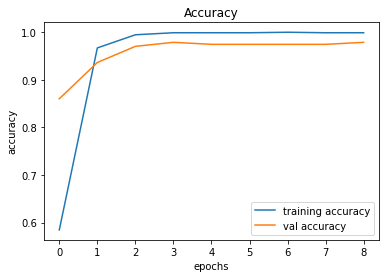

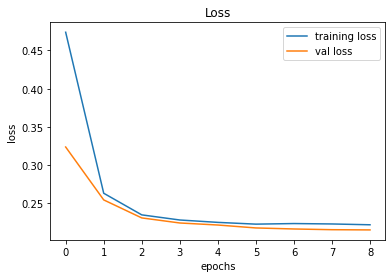

In [92]:
#plotting graphs for accuracy
plt.figure(0)
plt.plot(anc.history['accuracy'], label='training accuracy')
plt.plot(anc.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(anc.history['loss'], label='training loss')
plt.plot(anc.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [93]:
y_pred=model5.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

8/8 [==============================] - 4s 141ms/step


In [94]:
y_pred

array([0, 6, 0, 8, 6, 6, 6, 5, 0, 4, 4, 1, 7, 5, 0, 1, 4, 3, 0, 6, 0, 2,
       2, 7, 0, 2, 1, 2, 2, 4, 0, 3, 3, 0, 4, 8, 8, 4, 1, 8, 6, 4, 2, 2,
       8, 2, 3, 6, 7, 4, 3, 0, 2, 0, 7, 7, 3, 3, 7, 5, 6, 7, 2, 7, 5, 8,
       5, 4, 3, 2, 4, 6, 3, 0, 7, 5, 2, 2, 8, 3, 1, 2, 2, 2, 1, 2, 1, 5,
       6, 7, 2, 6, 7, 3, 6, 1, 4, 1, 3, 3, 7, 0, 8, 5, 8, 0, 8, 2, 5, 3,
       2, 0, 7, 2, 6, 1, 4, 2, 3, 1, 7, 8, 1, 1, 2, 2, 2, 1, 8, 4, 1, 3,
       7, 2, 1, 3, 6, 4, 1, 0, 1, 0, 0, 1, 8, 0, 8, 0, 6, 8, 2, 1, 6, 5,
       1, 7, 0, 5, 3, 3, 8, 3, 3, 1, 5, 5, 6, 5, 3, 0, 4, 7, 3, 0, 7, 6,
       3, 8, 6, 8, 4, 3, 3, 5, 2, 7, 1, 2, 8, 3, 4, 5, 1, 6, 7, 3, 8, 4,
       3, 4, 6, 0, 7, 5, 7, 0, 8, 8, 2, 2, 4, 5, 6, 8, 4, 0, 2, 0, 2, 5,
       8, 0, 0, 4, 4, 2, 0, 2, 8, 1, 2, 5, 2, 7, 2, 7])

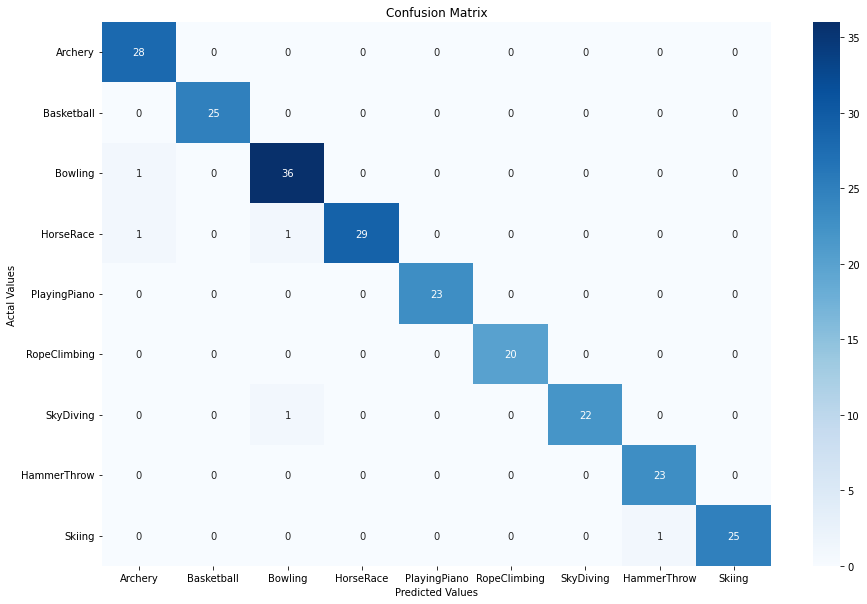

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test.argmax(axis=1), y_pred)

cm_df = pd.DataFrame(cm,
                     index =l, 
                     columns =l)
plt.figure(figsize=(15,10))
sns.heatmap(cm_df, annot=True, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [96]:
import cv2

In [97]:
def framing(video):#defining a small function named"framing" with a parameter "i" that's supposed to be provided for reading the video
    fr = []#creating an empty list named fr
    fr_pre=[]#creating an empty list named fr_pre
    cap = cv2.VideoCapture(video)#reading the video file
    while (cap.isOpened()):#This command builds a loop to check if the data is still being read from the video
        ret,frame = cap.read()#reading the data tunnel,gives two output where one tells about presence of frames(here it's ret) & the other speaks frame data(here it's frame)
        if ret == True:#checking for presence of frames
            # cv2_imshow(frame)#displaying the frames
            grayed = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)#Converting the frames to Grayscale from BGR
            canned = cv2.Canny(grayed,320,320)#For extrating edges we use Canny Edge detection method
            fr.append(frame)#Appending the read frame
            fr_pre.append(canned)#Appending the edge extracted frames
            # cv2_imshow(grayed)#Displaying the original frames
            # cv2_imshow(canned)#Displaying the edge detected frames
            k = cv2.waitKey(10) & 0XFF#this is an arrangement for displaying the video where the secs for which each frame needs to be displayed in given in the paranthesis
            if k == ord('q'):#pressing 'q' key will close the video
                break
        else:
            break
    cap.release()#Here we release the resoures
    cv2.destroyAllWindows()#Here we delete all the windows that were created during the program       
    return fr_pre,fr 

In [98]:
def difference_of_frames(frames):
    diff = []#creatin a list variable
    for i in range(0,len(frames)-1):#defining the range
        # print(frames[i],frames[i+1])#checking the frames presence
        diff.append(cv2.absdiff(frames[i],frames[i+1]))#appending the diff between frames to the list variable so we're supposed to get only the difference between frames
    return diff

In [99]:
def cal_threshold(diff):
  mn = np.mean(diff)#This gives mean
  st_d = np.std(diff)#This gives standard deviation
  a = 4#Setting a random value we can modify it to any value 
  ts = mn + (a * st_d)#defining the standard threshold value for the project/global threshold value
  return ts

In [100]:
def imp_frames(diff, ts, ogframes):
  a_fr = []#Creating an empty list
  for i in range(len(diff)):#Defining the for loop to be looped over all the frames obtained after finding the frames resulted from subtracting
      mn = np.mean(diff[i])#Calculating the mean for each frame
      st_d = np.std(diff[i])#Calculating the standard deviation for each frame
      fr_ts = mn + (4*st_d)#Finding the threshold values for each frame/image
      a_fr.append([i,fr_ts])#Appending the frame number & the threshold values
  imp_fr = []#Creating an empty list
  for i,ac_tr in(a_fr):#Defining the loop on the list obtained from above code
      if ac_tr >= ts:#Comapring the threshold values to the standard threshold/global threshold values
          imp_fr.append([i,ac_tr])#Appending the list with the imp frames based on their index & the values
  key_fr = []#Creating an empty list
  for i,_ in imp_fr:#Defining the loop over the list obtained from above code
      key_fr.append(ogframes[i])#This extracts the frames based on the index of frames 
  return key_fr

In [101]:
def final_image(video):
  frames,ogframes = framing(video)#calling function framing & then extracting the images 
  diff=difference_of_frames(frames)  
  ts=cal_threshold(diff) 
  key_fr=imp_frames(diff, ts, ogframes)  
  frame_no=key_fr[int(len(key_fr)/2)] #this is a frame
  cv2.imwrite("/content/Testing1.jpg",frame_no)
  return "/content/Testing1.jpg"
  cv2.destroyAllWindows()

In [102]:
def image_test(image_path):
  image=Image.open(image_path)
  image = image.resize((224,224)) 
  image = np.array(image) 
  image= np.expand_dims(image, axis=0)
  return image

In [103]:
path=final_image("/content/Skiing.mp4")

In [104]:
def largest_indices(ary, n):
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return indices

In [105]:
image=image_test(path)
# print(image.shape)
output_class=model5.predict(image)
indices=largest_indices(output_class, 4)
print(le.inverse_transform(indices))

1/1 [==============================] - 0s 38ms/step
['Skiing' 'Bowling' 'RopeClimbing' 'Archery']
